In [12]:
%pip install numpy
%pip install pandas
%pip install xgboost
%pip install scikit-learn
%pip install matplotlib
%pip install pyarrow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached pyarrow-22.0.0-cp313-cp313-win_amd64.whl.metadata (3.3 kB)
Using cached pyarrow-22.0.0-cp313-cp313-win_amd64.whl (28.0 MB)
Note: you may need to restart the kernel to use updated packages.


In [6]:
import numpy as np
import pandas as pd
from scipy import stats
import gc

import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

In [10]:
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc

# 1. 운영체제에 따른 폰트 설정
system_name = platform.system()

if system_name == 'Windows':
    # 윈도우의 경우 '맑은 고딕' 설정
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print("Unknown system... sorry")

# 2. 마이너스(-) 기호가 깨지는 현상 방지
plt.rcParams['axes.unicode_minus'] = False

print("한글 폰트 설정 완료!")

한글 폰트 설정 완료!


In [13]:
# 데이터 분할(폴더) 구분
data_splits = ["train", "test"]

# 각 데이터 유형별 폴더명, 파일 접미사, 변수 접두어 설정
data_categories = {
    "회원정보": {"folder": "1.회원정보", "suffix": "회원정보", "var_prefix": "customer"},
    "신용정보": {"folder": "2.신용정보", "suffix": "신용정보", "var_prefix": "credit"},
    "승인매출정보": {"folder": "3.승인매출정보", "suffix": "승인매출정보", "var_prefix": "sales"},
    "청구정보": {"folder": "4.청구입금정보", "suffix": "청구정보", "var_prefix": "billing"},
    "잔액정보": {"folder": "5.잔액정보", "suffix": "잔액정보", "var_prefix": "balance"},
    "채널정보": {"folder": "6.채널정보", "suffix": "채널정보", "var_prefix": "channel"},
    "마케팅정보": {"folder": "7.마케팅정보", "suffix": "마케팅정보", "var_prefix": "marketing"},
    "성과정보": {"folder": "8.성과정보", "suffix": "성과정보", "var_prefix": "performance"}
}

for split in data_splits:
    for category, info in data_categories.items():
        folder = info["folder"]
        suffix = info["suffix"]
        var_prefix = info["var_prefix"]
        
        file_path = f"./data/{folder}/{split}_{suffix}.parquet"
        # 변수명 형식: {var_prefix}_{split}_{month}
        variable_name = f"{var_prefix}_{split}"
        globals()[variable_name] = pd.read_parquet(file_path, engine="pyarrow")
        print(f"{variable_name} is loaded from {file_path}")

gc.collect()

ArrowKeyError: No type extension with name arrow.py_extension_type found

In [ ]:
# 데이터 유형별 설정 
info_categories = ["customer", "credit", "sales", "billing", "balance", "channel", "marketing", "performance"]

In [ ]:
#### Train data ####

# 각 유형별로 월별 데이터를 합쳐서 새로운 변수에 저장
train_dfs = {}

for prefix in info_categories:
    # globals()에서 동적 변수명으로 데이터프레임들을 가져와 리스트에 저장
    df_list = [globals()[f"{prefix}_train"]]
    train_dfs[f"{prefix}_train_df"] = pd.concat(df_list, axis=0)
    gc.collect()
    print(f"{prefix}_train_df is created with shape: {train_dfs[f'{prefix}_train_df'].shape}")

customer_train_df = train_dfs["customer_train_df"]
credit_train_df   = train_dfs["credit_train_df"]
sales_train_df    = train_dfs["sales_train_df"]
billing_train_df  = train_dfs["billing_train_df"]
balance_train_df  = train_dfs["balance_train_df"]
channel_train_df  = train_dfs["channel_train_df"]
marketing_train_df= train_dfs["marketing_train_df"]
performance_train_df = train_dfs["performance_train_df"]

gc.collect()

customer_train_df is created with shape: (400000, 78)
credit_train_df is created with shape: (400000, 42)
sales_train_df is created with shape: (400000, 406)
billing_train_df is created with shape: (400000, 46)
balance_train_df is created with shape: (400000, 82)
channel_train_df is created with shape: (400000, 105)
marketing_train_df is created with shape: (400000, 64)
performance_train_df is created with shape: (400000, 49)


0

In [ ]:
from functools import reduce

# 공통 ID 컬럼명
COMMON_ID = 'ID' 
# 삭제할 중복 컬럼명
CONFLICT_COL = '기준년월' 

# DF
data_to_merge = [
    customer_train_df,
    credit_train_df,
    sales_train_df,
    billing_train_df,
    balance_train_df,
    channel_train_df,
    marketing_train_df,
    performance_train_df
]

all_train_dfs_processed = []

print(f"--- Dropping '{CONFLICT_COL}' column before merge ---")

# 1. 각 DF에서 COMMON_ID가 아닌 '기준년월' 컬럼 삭제
for i, df in enumerate(data_to_merge):
    df_processed = df.copy()
    
    # 해당 컬럼이 존재하고, ID 컬럼이 아닌 경우에만 삭제
    if CONFLICT_COL in df_processed.columns and CONFLICT_COL != COMMON_ID:
        df_processed = df_processed.drop(columns=[CONFLICT_COL])
        print(f"Dropped '{CONFLICT_COL}' from DataFrame {i+1}")
    
    all_train_dfs_processed.append(df_processed)

# 2. '기준년월'이 삭제된 DF 리스트로 reduce merge 실행
print("\nStarting merge...")
merged_train_df = reduce(
    lambda left, right: pd.merge(left, right, on=COMMON_ID, how='left'), 
    all_train_dfs_processed
)

print(f"--- Merge successful! ---")
print(f"최종 병합된 데이터 Shape: {merged_train_df.shape}") # 열 단위로 병합된 데이터 

--- Dropping '기준년월' column before merge ---
Dropped '기준년월' from DataFrame 1
Dropped '기준년월' from DataFrame 2
Dropped '기준년월' from DataFrame 3
Dropped '기준년월' from DataFrame 4
Dropped '기준년월' from DataFrame 5
Dropped '기준년월' from DataFrame 6
Dropped '기준년월' from DataFrame 7
Dropped '기준년월' from DataFrame 8

Starting merge...
--- Merge successful! ---
최종 병합된 데이터 Shape: (400000, 857)


In [ ]:
# (이산형, 수치형) 데이터로 나누기 
target_col = 'Segment'
id_col = ['customer_id']

features_df = merged_train_df.drop(columns=[target_col] + id_col, errors='ignore')

Discrimination_criteria = 30 # 30 개를 기준으로 이산형, 수치형으로 분류

# object, categorical은 미리 이산형으로 분류
initial_categorical = features_df.select_dtypes(include=['object', 'category']).columns.tolist()
initial_numerical = features_df.select_dtypes(include=np.number).columns.tolist()

refined_numerical_features = []
refined_categorical_features = list(initial_categorical) 

# 수치형 피처들을 다시 검토
for col in initial_numerical:
    if features_df[col].nunique() < Discrimination_criteria:
        refined_categorical_features.append(col)
    else:
        refined_numerical_features.append(col)

print(f"--- 정제된 피처 분리 결과 (임계값: {Discrimination_criteria}) ---")
print(f"수치형 피처: {len(refined_numerical_features)}개")
print(f"범주형 피처: {len(refined_categorical_features)}개")    

--- 정제된 피처 분리 결과 (임계값: 30) ---
수치형 피처: 351개
범주형 피처: 505개


In [ ]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.feature_selection import f_classif, chi2
import warnings

# --- 0. 타겟 변수(y) 인코딩 ---
y = merged_train_df[target_col]

# 'Segment' (A~E)를 숫자(0~4)로 변환
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# --- 1. 수치형 피처 (Numerical) → ANOVA F-test ---
print("\n--- 1. 수치형 피처 vs. 타겟 (ANOVA F-test) ---")

# 결측치를 0으로 단순 대체 (추후 더 나은 imputation 방법 고려)
X_num = features_df[refined_numerical_features].fillna(0)

# ANOVA F-test 실행
f_scores, p_values = f_classif(X_num, y_encoded)

# 결과를 DataFrame으로 정리
num_results_df = pd.DataFrame({
    'Feature': refined_numerical_features,
    'F_Score': f_scores,
    'P_Value': p_values
})

# P_Value가 낮은 순(연관성이 높은 순)으로 정렬
num_results_df = num_results_df.sort_values(by='P_Value', ascending=True)
num_results_df = num_results_df.sort_values(by='F_Score', ascending=False)


print("타겟과 연관성 높은 수치형 피처 TOP 50:")
print(num_results_df.head)


# --- 2. 범주형 피처 (Categorical) → Chi-Squared ---

print("\n--- 2. 범주형 피처 vs. 타겟 (Chi-Squared) ---")

# 전처리 : 모든 범주형 피처를 '문자열'로 변환하고 결측치를 'Missing'으로 대체
X_cat = features_df[refined_categorical_features].astype(str).fillna('Missing')

# 범주형 피처들을 숫자로 인코딩 (Chi-Squared는 숫자 입력만 받음)
encoder = OrdinalEncoder()
X_cat_encoded = encoder.fit_transform(X_cat)

# Chi-Squared 테스트 실행
chi_scores, p_values = chi2(X_cat_encoded, y_encoded)

# 결과를 DataFrame으로 정리
cat_results_df = pd.DataFrame({
    'Feature': refined_categorical_features,
    'Chi2_Score': chi_scores,
    'P_Value': p_values
})

# P_Value가 낮은 순(연관성이 높은 순)으로 정렬
cat_results_df = cat_results_df.sort_values(by='P_Value', ascending=True)
cat_results_df = cat_results_df.sort_values(by='Chi2_Score', ascending=False)

print("타겟과 연관성 높은 범주형 피처 TOP 50:")
print(cat_results_df.head)


--- 1. 수치형 피처 vs. 타겟 (ANOVA F-test) ---
타겟과 연관성 높은 수치형 피처 TOP 50:
<bound method NDFrame.head of                Feature       F_Score   P_Value
207         정상청구원금_B5M  73956.952736  0.000000
199         정상청구원금_B0M  70749.746063  0.000000
203         정상청구원금_B2M  69233.371386  0.000000
3        이용금액_R3M_신용체크  66105.622588  0.000000
215           청구금액_R6M  57040.790862  0.000000
..                 ...           ...       ...
253        연체잔액_할부_B0M      1.663632  0.155313
146  할부금액_무이자_14M_R12M      1.039589  0.385000
251           연체잔액_B0M      0.908552  0.457768
277        연체잔액_CA_B0M      0.589492  0.670236
228      포인트_잔여포인트_B0M      0.495042  0.739407

[351 rows x 3 columns]>

--- 2. 범주형 피처 vs. 타겟 (Chi-Squared) ---
타겟과 연관성 높은 범주형 피처 TOP 50:
<bound method NDFrame.head of               Feature     Chi2_Score  P_Value
250      이용건수_온라인_B0M  369574.427008      0.0
253   이용건수_페이_온라인_R6M  327784.600098      0.0
276     이용건수_간편결제_R3M  289550.492648      0.0
188      할부건수_6M_R12M  231339.1262

In [ ]:
print('수치형 데이터의 높은 연관성 : (청구원금, 이용금액)')
print('이산형 데이터의 높은 연관성 : (온라인 이용, 페이(간편결제) 및 할부)')

수치형 데이터의 높은 연관성 : (청구원금, 이용금액)
이산형 데이터의 높은 연관성 : (온라인 이용, 페이(간편결제) 및 할부)


In [ ]:
# ---결측치 존재 여부 및 패턴---

TOP_N = 50
# 1. 수치형 피처 상위 N개 추출
top_num_features = num_results_df['Feature'].head(TOP_N).tolist()

# 2. 범주형 피처 상위 N개 추출
top_cat_features = cat_results_df['Feature'].head(TOP_N).tolist()

key_features = top_num_features + top_cat_features

# 1. 전체 데이터프레임의 결측치 개수 확인
total_missing = merged_train_df.isnull().sum()

# 2. 결측치가 많은 순서로 정렬
missing_count_sorted = total_missing.sort_values(ascending=False)
# print("--- 결측치 많은 순서 (상위 20개) ---")
# #print(missing_count_sorted.head(20)) # 나중에 결측치가 90% 이상이면 drop 하기 

# 3. 선별한 '중요 피처'들의 결측치 개수 확인
print("\n--- 주요 피처 결측치 현황 ---")
print(total_missing[key_features])
aaaa = total_missing[key_features]


--- 주요 피처 결측치 현황 ---
정상청구원금_B5M            0
정상청구원금_B0M            0
정상청구원금_B2M            0
이용금액_R3M_신용체크         0
청구금액_R6M              0
                  ...  
_2순위교통업종         279291
_3순위업종           189334
이용카드수_신용체크            0
이용개월수_CA_R3M          0
이용후경과월_신판             0
Length: 100, dtype: int64


In [ ]:
# --- 이상치 검출  ---

def detect_outliers_iqr_safe(df, column):
    series = pd.to_numeric(df[column], errors='coerce')
    
    # 2. 결측치 제외하고 계산
    series = series.dropna()
    
    if len(series) == 0:
        return pd.DataFrame() # 데이터 없으면 빈 DF 반환

    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # 3. 이상치 필터링
    outliers = df.loc[(series < lower_bound) | (series > upper_bound)]
    
    # 결과 출력
    if len(outliers) > 0:
        print(f"[IQR] {column} 이상치 개수: {len(outliers)}개")
    
    return outliers


print("\n--- 주요 수치형 피처 이상치 검출 시작 ---")
for col in top_num_features[:50]: 
    detect_outliers_iqr_safe(merged_train_df, col)


print("\n--- 주요 범주형 피처 이상치 검출 시작 ---")
for col in top_cat_features[:50]: 
    detect_outliers_iqr_safe(merged_train_df, col)

# 특정 피처 하나만 보고 싶을 때:
# target_feature = '이용금액_R3M_신용체크' # (예시 컬럼명)
# detect_outliers_iqr_safe(merged_train_df, target_feature)


--- 주요 수치형 피처 이상치 검출 시작 ---
[IQR] 정상청구원금_B5M 이상치 개수: 24733개
[IQR] 정상청구원금_B0M 이상치 개수: 31438개
[IQR] 정상청구원금_B2M 이상치 개수: 29982개
[IQR] 이용금액_R3M_신용체크 이상치 개수: 33854개
[IQR] 청구금액_R6M 이상치 개수: 28850개
[IQR] 청구금액_R3M 이상치 개수: 29282개
[IQR] 이용금액_R3M_신용 이상치 개수: 32957개
[IQR] 이용금액_오프라인_R3M 이상치 개수: 36984개
[IQR] 이용금액_일시불_R12M 이상치 개수: 29917개
[IQR] _1순위카드이용금액 이상치 개수: 20877개
[IQR] 이용금액_오프라인_B0M 이상치 개수: 37291개
[IQR] 이용금액_일시불_R3M 이상치 개수: 23574개
[IQR] 이용금액_일시불_B0M 이상치 개수: 24493개
[IQR] 청구금액_B0 이상치 개수: 29874개
[IQR] 이용금액_일시불_R6M 이상치 개수: 25571개
[IQR] 이용금액_오프라인_R6M 이상치 개수: 22729개
[IQR] 정상입금원금_B2M 이상치 개수: 23643개
[IQR] 정상입금원금_B0M 이상치 개수: 24394개
[IQR] 정상입금원금_B5M 이상치 개수: 29809개
[IQR] _3순위업종_이용금액 이상치 개수: 17468개
[IQR] _2순위업종_이용금액 이상치 개수: 26836개
[IQR] _2순위쇼핑업종_이용금액 이상치 개수: 10893개
[IQR] 최대이용금액_일시불_R12M 이상치 개수: 30448개
[IQR] 이용건수_신용_R12M 이상치 개수: 27526개
[IQR] 이용건수_신판_R12M 이상치 개수: 27710개
[IQR] _1순위업종_이용금액 이상치 개수: 31478개
[IQR] 이용건수_일시불_R12M 이상치 개수: 27942개
[IQR] _3순위쇼핑업종_이용금액 이상치 개수: 10290개
[IQR] 이용건수_오프라인_R3M 이상치 개수: 22888개
[IQR

In [ ]:
bbbb = pd.DataFrame(merged_train_df.columns)

In [ ]:
print("전처리 : 데이터 수정 및 변환 시작\n")
# 최종 피처
final_features = top_num_features + top_cat_features # 수처형 50개 , 범주형 50개
X = merged_train_df[final_features].copy()

#수치형 데이터 전처리 
print("전처리 : 수치형 데이터 전처리 \n")
X[top_num_features] = X[top_num_features].fillna(0) # 결측치 처리 -> 0
X[top_num_features] = X[top_num_features].clip(lower=0) # 마이너스 값 제거 -> 0

# 극단치 캡핑 (상위 1% 초과 -> 상위 1%)
for col in top_num_features:
    p99 = X[col].quantile(0.99)
    X[col] = X[col].clip(upper=p99)

# 금액 데이터 등 분포를 정규분포에 가깝게 만듦 -> 로그 변환
for col in top_num_features:
    X[col] = np.log1p(X[col])

# 범주형 데이터 전처리
print("전처리 : 범주형 데이터 전처리")
X[top_cat_features] = X[top_cat_features].fillna('Missing')

# label encoding 적용
le = LabelEncoder()
for col in top_cat_features:
    X[col] = X[col].astype(str)
    X[col] = le.fit_transform(X[col])

# 확인용 
print(X.shape)
print(y_encoded.shape)

전처리 : 데이터 수정 및 변환 시작

전처리 : 수치형 데이터 전처리 

전처리 : 범주형 데이터 전처리
(400000, 100)
(400000,)


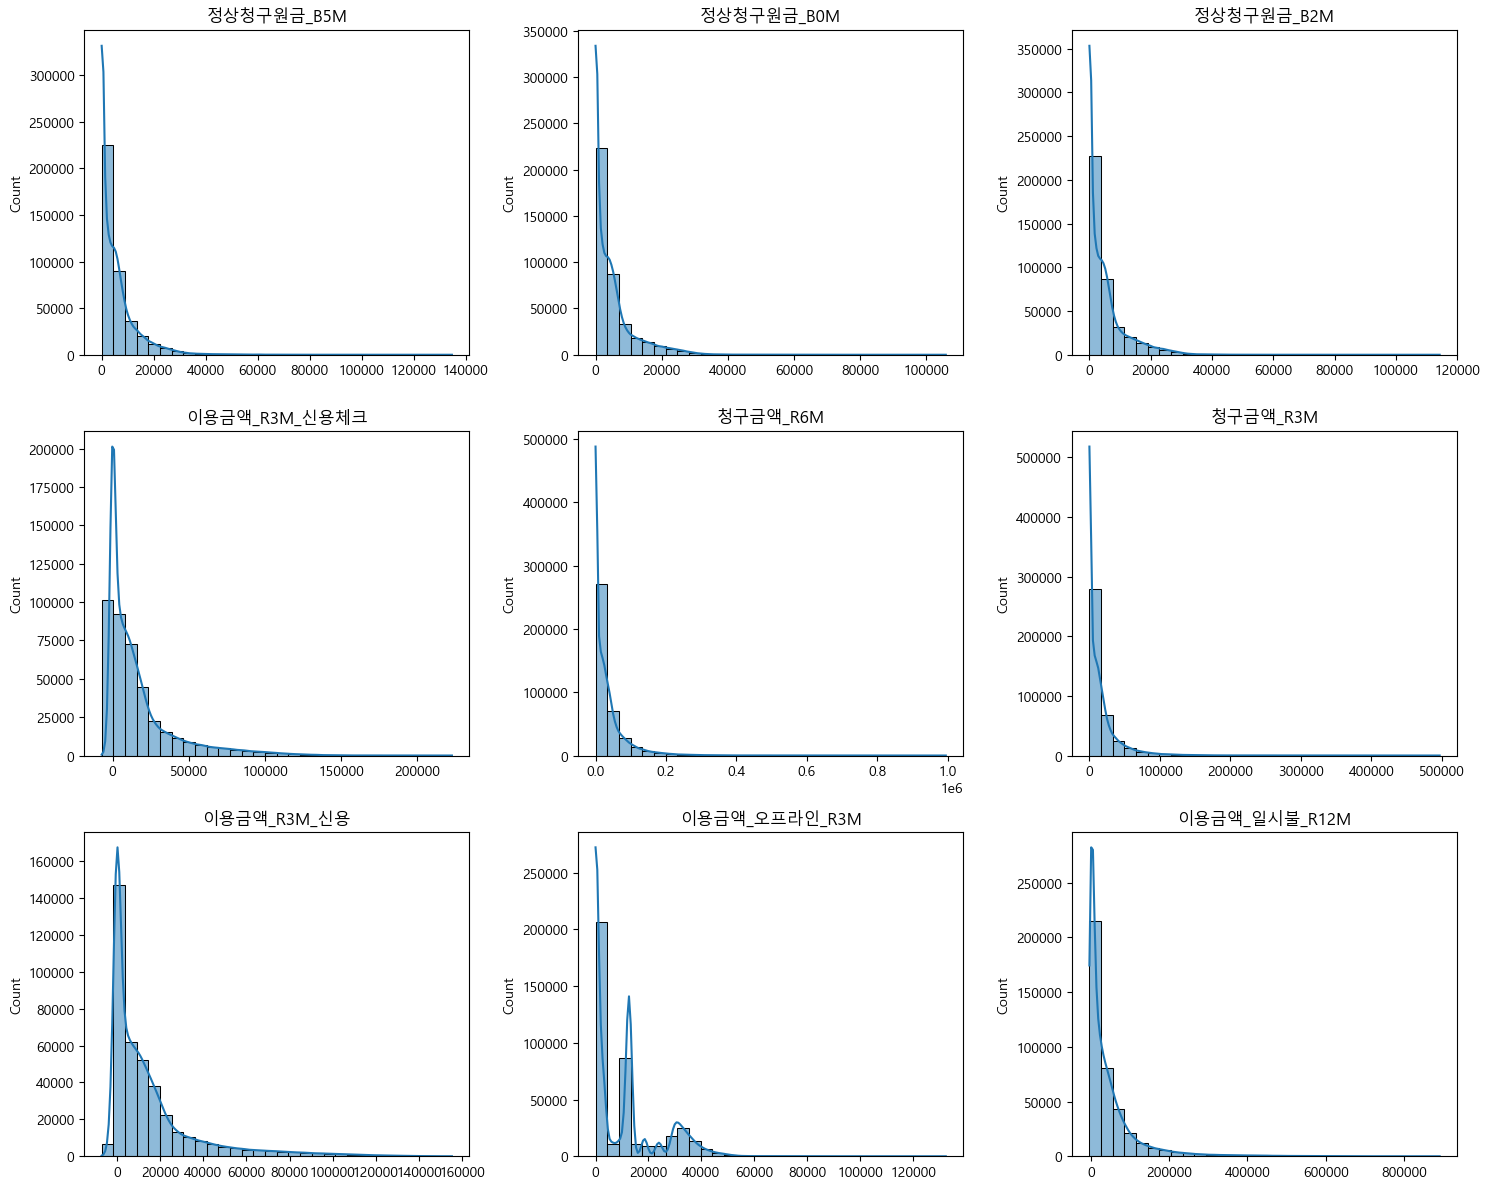

In [ ]:
# 수치형 데이터 그래프 

import seaborn as sns
import matplotlib.pyplot as plt

features_to_show = top_num_features[:9] 

plt.figure(figsize=(15, 12))

for i, col in enumerate(features_to_show):
    plt.subplot(3, 3, i+1) # 3행 3열 그리드
    # 로그 변환 전인지 후인지에 따라 모양이 다를 겁니다.
    sns.histplot(merged_train_df[col], kde=True, bins=30)
    plt.title(col)
    plt.xlabel('')

plt.tight_layout()
plt.show()

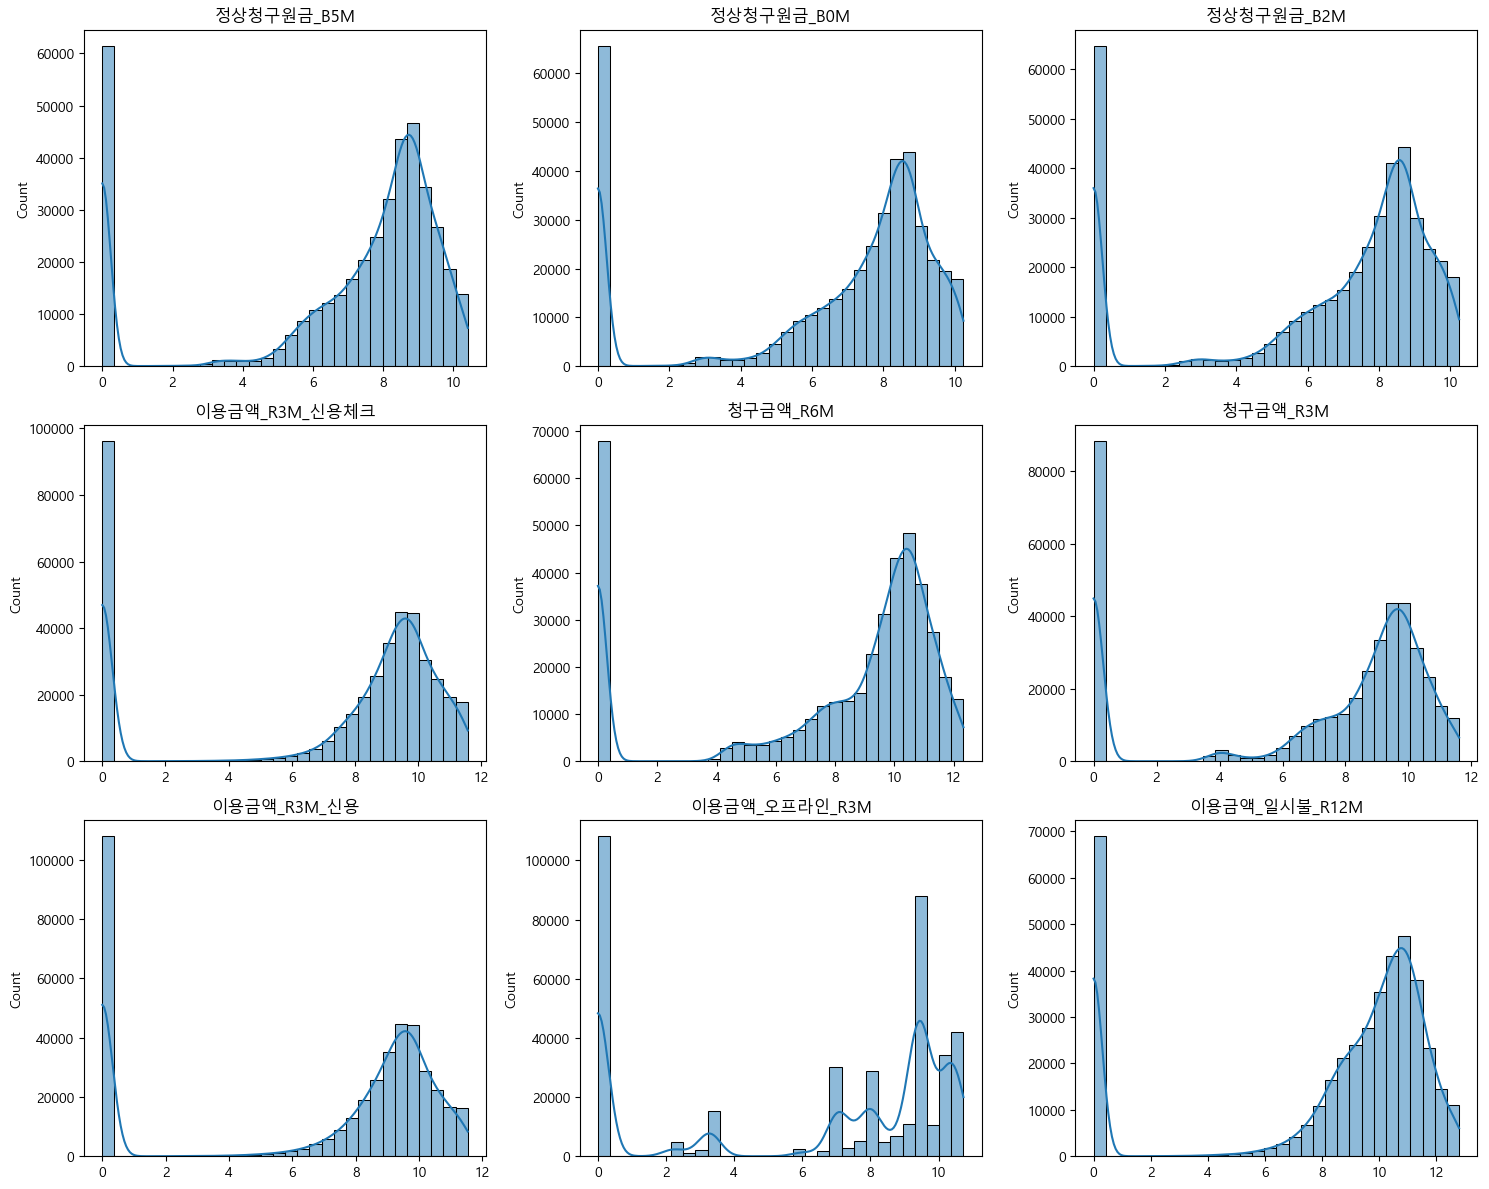

In [ ]:
features_to_show = X[top_num_features[:9]]

plt.figure(figsize=(15, 12))

for i, col in enumerate(features_to_show):
    plt.subplot(3, 3, i+1) # 3행 3열 그리드
    # 로그 변환 전인지 후인지에 따라 모양이 다를 겁니다.
    sns.histplot(X[col], kde=True, bins=30)
    plt.title(col)
    plt.xlabel('')

plt.tight_layout()
plt.show()

그리기 적합한 피처: 49개 (전체 50개 중)


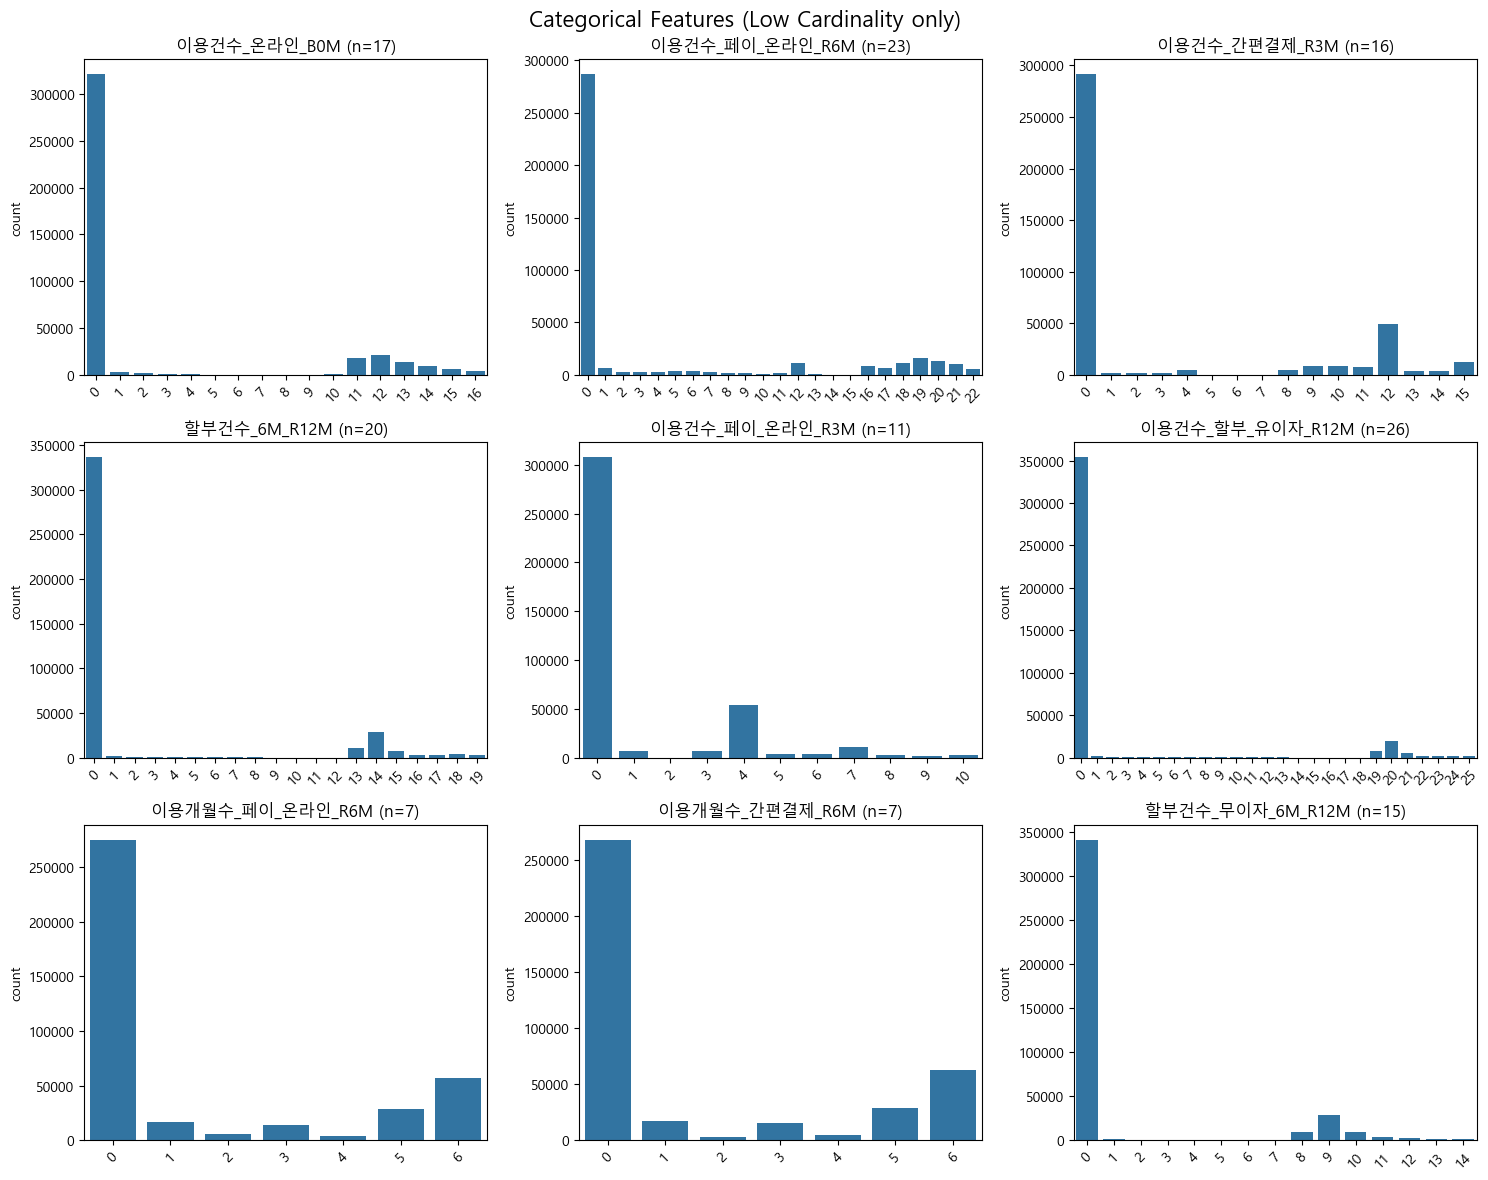

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

safe_cat_features = [col for col in top_cat_features if X[col].nunique() <= 50]

print(f"그리기 적합한 피처: {len(safe_cat_features)}개 (전체 {len(top_cat_features)}개 중)")

# 상위 9개만 그리기
features_to_show = safe_cat_features[:9]

plt.figure(figsize=(15, 12))
plt.suptitle("Categorical Features (Low Cardinality only)", fontsize=16)

for i, col in enumerate(features_to_show):
    plt.subplot(3, 3, i+1)
    
    # 막대그래프 그리기
    # x축 글씨가 겹치면 안 보이니까 90도 회전
    sns.countplot(x=X[col])
    plt.xticks(rotation=45) 
    plt.title(f"{col} (n={X[col].nunique()})")
    plt.xlabel('')

plt.tight_layout()
plt.show()

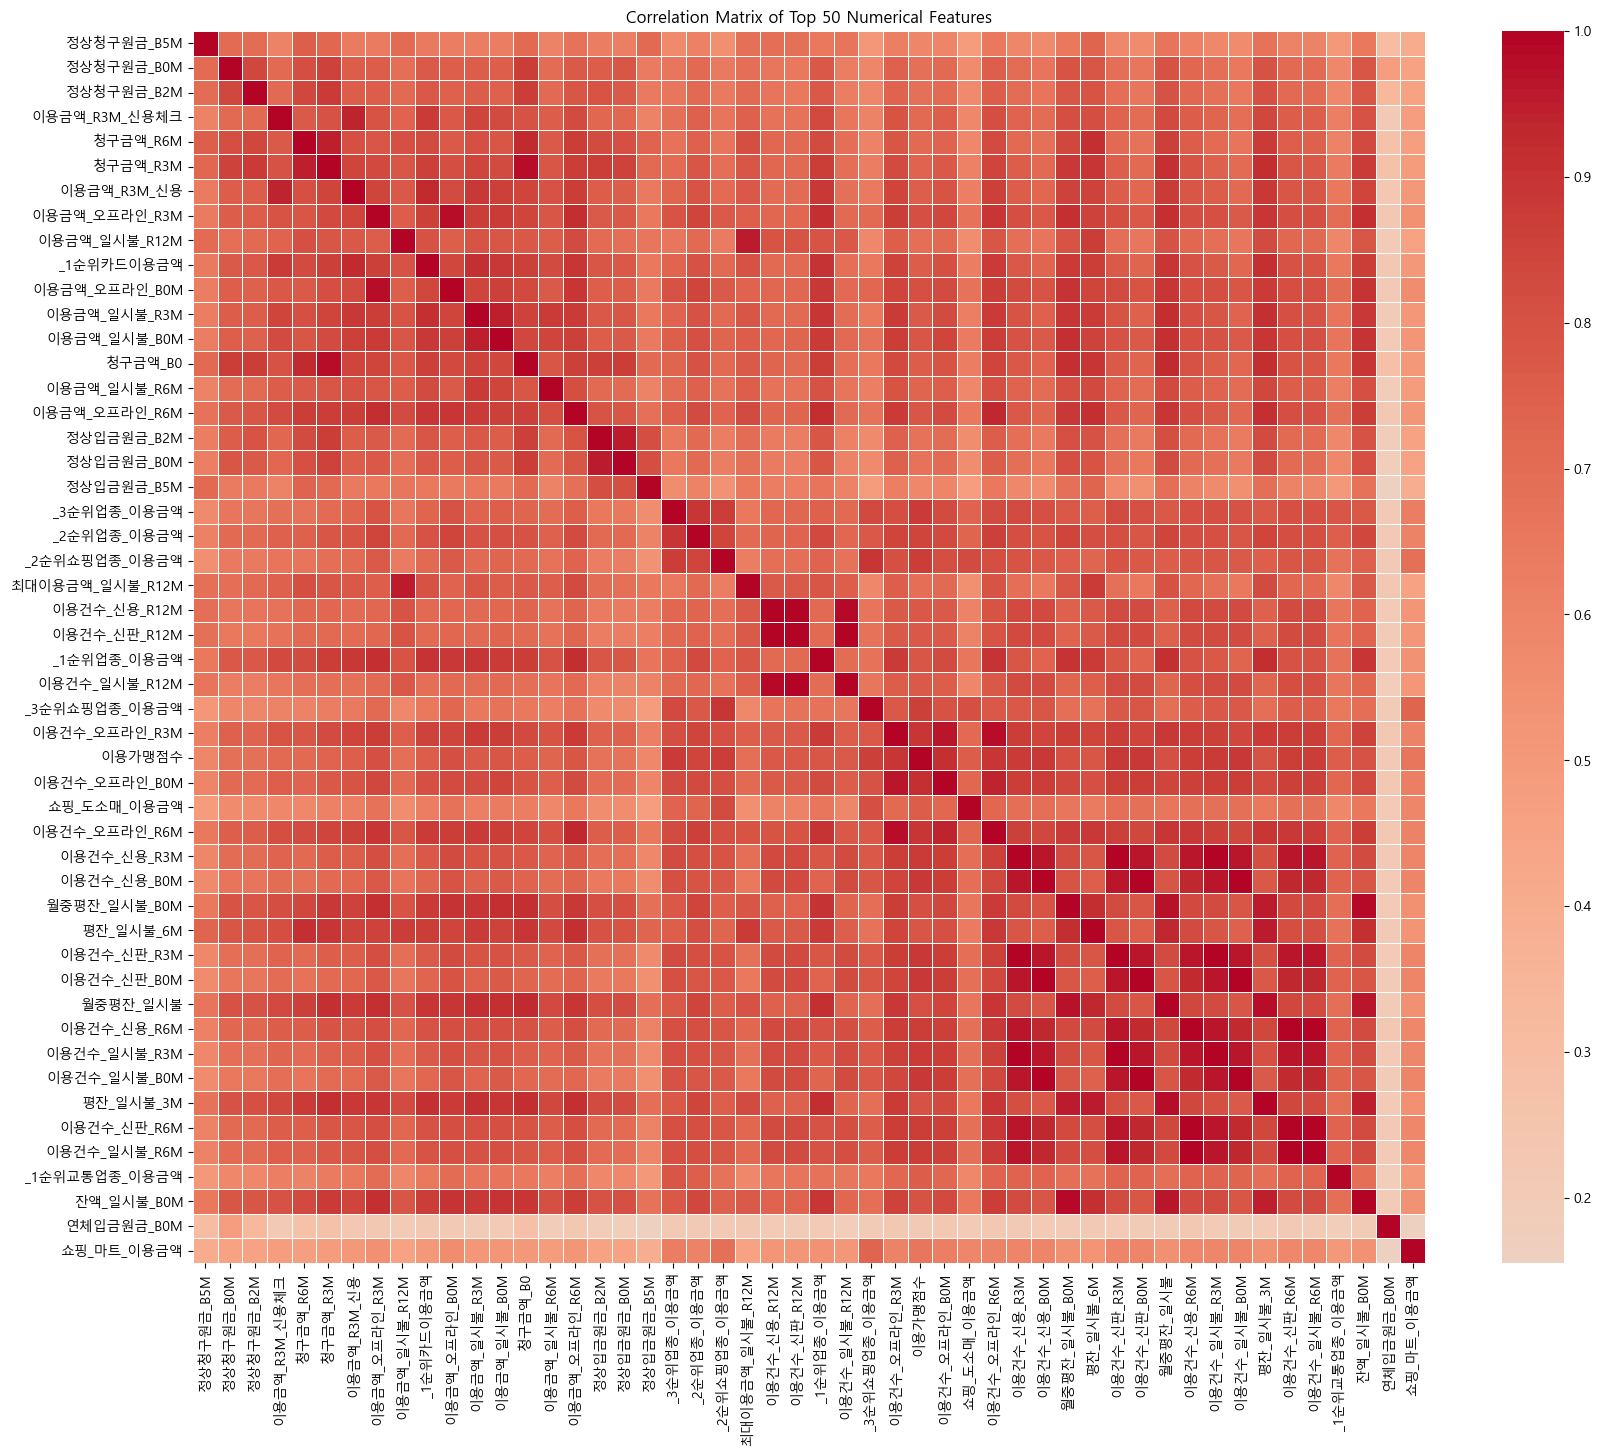

--- 중복 의심 피처 쌍 (상관계수 > 0.9) ---
이용금액_R3M_신용체크 <-> 이용금액_R3M_신용 : 0.9415
청구금액_R6M <-> 청구금액_R3M : 0.9444
청구금액_R6M <-> 청구금액_B0 : 0.9245
청구금액_R6M <-> 평잔_일시불_6M : 0.9123
청구금액_R3M <-> 청구금액_B0 : 0.9789
청구금액_R3M <-> 월중평잔_일시불 : 0.9051
청구금액_R3M <-> 평잔_일시불_3M : 0.9165
이용금액_R3M_신용 <-> _1순위카드이용금액 : 0.9274
이용금액_오프라인_R3M <-> 이용금액_오프라인_B0M : 0.9740
이용금액_오프라인_R3M <-> 이용금액_오프라인_R6M : 0.9179
이용금액_오프라인_R3M <-> _1순위업종_이용금액 : 0.9074
이용금액_오프라인_R3M <-> 월중평잔_일시불_B0M : 0.9114
이용금액_오프라인_R3M <-> 월중평잔_일시불 : 0.9043
이용금액_오프라인_R3M <-> 잔액_일시불_B0M : 0.9105
이용금액_일시불_R12M <-> 최대이용금액_일시불_R12M : 0.9538
_1순위카드이용금액 <-> 이용금액_일시불_R3M : 0.9108
_1순위카드이용금액 <-> _1순위업종_이용금액 : 0.9019
_1순위카드이용금액 <-> 평잔_일시불_3M : 0.9071
이용금액_오프라인_B0M <-> 잔액_일시불_B0M : 0.9003
이용금액_일시불_R3M <-> 이용금액_일시불_B0M : 0.9464
이용금액_일시불_R3M <-> 월중평잔_일시불 : 0.9165
이용금액_일시불_R3M <-> 평잔_일시불_3M : 0.9116
이용금액_일시불_B0M <-> 월중평잔_일시불_B0M : 0.9054
이용금액_일시불_B0M <-> 월중평잔_일시불 : 0.9070
청구금액_B0 <-> 월중평잔_일시불_B0M : 0.9045
청구금액_B0 <-> 월중평잔_일시불 : 0.9209
청구금액_B0 <-> 평잔_일시불_3M : 0.9154
이용금액_

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# (★) Top 50 수치형 피처 사용
# top_num_features는 이전에 정의됨
features_to_check = top_num_features[:50]

# 1. 상관계수 행렬 계산
corr_matrix = X[features_to_check].corr()

# 2. 히트맵 그리기
plt.figure(figsize=(20, 16))
sns.heatmap(
    corr_matrix, 
    annot=False,    # 숫자는 너무 많으니 뺍니다
    cmap='coolwarm', # 빨강(양의 상관), 파랑(음의 상관)
    center=0,
    square=True,
    linewidths=.5
)
plt.title('Correlation Matrix of Top 50 Numerical Features')
plt.show()

# 3. (옵션) 상관계수가 아주 높은(0.9 이상) 쌍 찾기
print("--- 중복 의심 피처 쌍 (상관계수 > 0.9) ---")
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            pair = (corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])
            high_corr_pairs.append(pair)
            print(f"{pair[0]} <-> {pair[1]} : {pair[2]:.4f}")

if not high_corr_pairs:
    print("0.9 이상의 강한 상관관계를 가진 피처가 없습니다.")

In [ ]:
# 변수간 산관관계가 너무 높으면 제거 
THRESHOLD = 0.90

print("--- 다중공선성(중복) 제거 시작 ---")

# 1. [안전장치] 현재 X에 실제로 존재하는 수치형 피처만 골라내기
current_num_features = [f for f in top_num_features if f in X.columns]

if len(current_num_features) == 0:
    print("수치형 피처가 없거나 이미 모두 처리되었습니다.")

else:
    # 2. 상관계수 행렬 계산
    corr_matrix = X[current_num_features].corr().abs()

    # 3. 대각선 위쪽만 확인 (중복 방지)
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # 4. 제거할 컬럼 찾기
    to_drop = [column for column in upper.columns if any(upper[column] > THRESHOLD)]

    print(f"제거할 중복 피처 개수: {len(to_drop)}개")
    print(f"제거 목록: {to_drop}")

    # 5. 실제로 존재하는 컬럼만 삭제 (errors='ignore'로 에러 무시)
    X = X.drop(columns=to_drop, errors='ignore')

    # 6. 최종 피처 리스트 업데이트
    final_features = [f for f in final_features if f in X.columns]

    print(f"\n--- 최종 피처 개수: {len(final_features)}개 ---")
    print(f"X shape: {X.shape}")

--- 다중공선성(중복) 제거 시작 ---
제거할 중복 피처 개수: 0개
제거 목록: []

--- 최종 피처 개수: 72개 ---
X shape: (400000, 72)
